# Dashboard in Python

Experiment making the same D3 plots but using Python tools.


In [2]:
import altair as alt
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# Load data
df = pd.read_csv(Path('../MER_T01_03.csv'))
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

In [4]:
# Inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8148 entries, 0 to 8147
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           8148 non-null   object 
 1   YYYYMM        8148 non-null   int64  
 2   Value         7816 non-null   float64
 3   Column_Order  8148 non-null   int64  
 4   Description   8148 non-null   object 
 5   Unit          8148 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 382.1+ KB


In [5]:
df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLTCBUS,194913,11.980905,1,Coal Consumption,Quadrillion Btu
1,CLTCBUS,195013,12.347109,1,Coal Consumption,Quadrillion Btu
2,CLTCBUS,195113,12.552996,1,Coal Consumption,Quadrillion Btu
3,CLTCBUS,195213,11.306479,1,Coal Consumption,Quadrillion Btu
4,CLTCBUS,195313,11.372684,1,Coal Consumption,Quadrillion Btu


In [6]:
# Label annual vs monthly numbers
def get_period(date):
    if str(date)[4:6] == '13':
        return 'annual'
    else:
        return 'monthly'


df['date'] = pd.to_datetime(df['YYYYMM'], format='%Y%M', errors='raise')
df['period'] = df['YYYYMM'].apply(get_period)

In [7]:
df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit,date,period
0,CLTCBUS,194913,11.980905,1,Coal Consumption,Quadrillion Btu,1949-01-01 00:13:00,annual
1,CLTCBUS,195013,12.347109,1,Coal Consumption,Quadrillion Btu,1950-01-01 00:13:00,annual
2,CLTCBUS,195113,12.552996,1,Coal Consumption,Quadrillion Btu,1951-01-01 00:13:00,annual
3,CLTCBUS,195213,11.306479,1,Coal Consumption,Quadrillion Btu,1952-01-01 00:13:00,annual
4,CLTCBUS,195313,11.372684,1,Coal Consumption,Quadrillion Btu,1953-01-01 00:13:00,annual


The raw data from EIA is in long format and contains both annual and monthly numbers for select years. Here we will limit our analysis to the annual numbers.


In [8]:
df_annual = df.query('period == "annual"')
df_annual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 0 to 8142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MSN           888 non-null    object        
 1   YYYYMM        888 non-null    int64         
 2   Value         808 non-null    float64       
 3   Column_Order  888 non-null    int64         
 4   Description   888 non-null    object        
 5   Unit          888 non-null    object        
 6   date          888 non-null    datetime64[ns]
 7   period        888 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 62.4+ KB


# Seaborn

No interactivity available for better or worse.


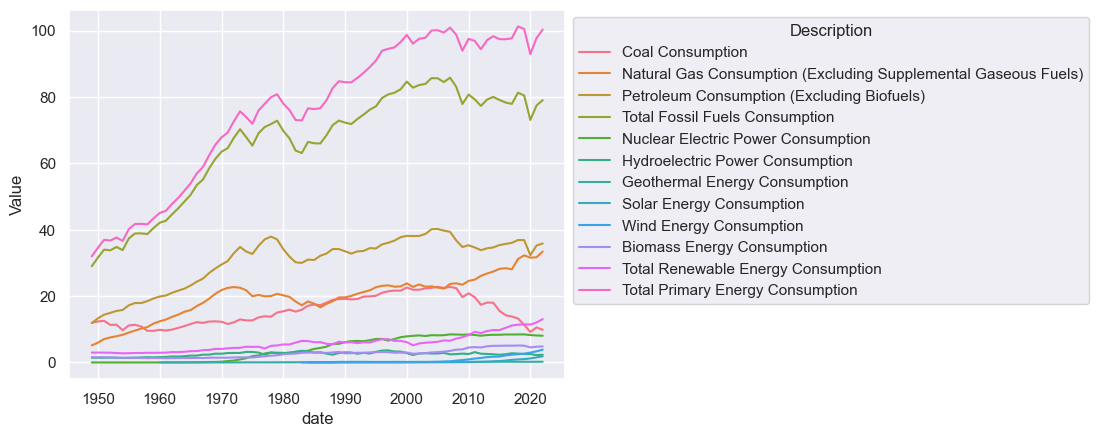

In [9]:
ax = sns.lineplot(data=df_annual,
                  x="date", y="Value",
                  hue="Description")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Altair, version 1

Interact by clicking on a line.


In [12]:
single = alt.selection_point()

line = alt.Chart(df_annual).mark_line(interpolate='basis').encode(
    x=alt.X('date:T', title='Year'),
    y=alt.Y('Value:Q', title='Energy Consumption (Quadrillion Btu)'),
    color=alt.condition(single, 'Description:N', alt.value('lightgray')),
    tooltip='Description:N'
).add_params(
    single
).configure_axis(
    grid=False
).configure_view(
    stroke=None
).properties(
    width=500, height=300
)

line.save('altair2.json')

line

alt.Chart(...)

# Altair, version 2

Interact by hovering over a line.


In [13]:
highlight = alt.selection_point(
    on='mouseover', fields=['Description'], nearest=True)

base = alt.Chart(df_annual).encode(
    x=alt.X('date:T', title='Year'),
    y=alt.Y('Value:Q', title='Energy Consumption (Quadrillion Btu)'),
    color=alt.Color('Description:N', legend=None),
    tooltip='Description:N',
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_params(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

chart = points + lines

chart = chart.configure_axis(
    grid=False
).configure_view(
    stroke=None
)

chart.save('altair1.html')
chart.save('altair1.json')

chart

alt.LayerChart(...)

Let's test an example of utilizing a selection in one chart to update the data shown in another chart.

Source: https://matthewkudija.com/blog/2018/06/22/altair-interactive/


In [15]:
from vega_datasets import data

color = alt.Color('Wildlife__Species:N')

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_circle().encode(
    alt.X('yearmonthdate(Flight_Date):T', axis=alt.Axis(title='Date')),
    alt.Y('Speed_IAS_in_knots:Q',
          axis=alt.Axis(title='Indicated Airspeed (kts)'),
          ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    tooltip=['Airport__Name:N', 'Aircraft__Make_Model:N', 'Flight_Date:T',
             'When__Phase_of_flight:N', 'Wildlife__Species:N', 'Speed_IAS_in_knots:Q'],
).properties(
    width=600,
    height=300
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of species
bars = alt.Chart().mark_bar().encode(
    alt.Y('count()', scale=alt.Scale(type='log')),
    # alt.X('Wildlife__Species:N', sort=alt.SortField(field='sort_order',
    #         op='count', order='descending')),
    alt.X('Wildlife__Species:N'),
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=600,
).add_selection(
    click
)

alt.vconcat(points, bars,
            data=data.birdstrikes.url,
            title="Aircraft Birdstrikes: 1990-2003"
            )

alt.VConcatChart(...)